In [4]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import slab_tracker_utils as slab
import splits_and_merges as snm
import slab_cross_section_utils as sxs
import slab_workflow
import xarray as xr
from os import walk

import rockhound as rh
from rockhound.slab2 import ZONES
import pygmt
import cartopy.crs as ccrs
%matplotlib inline


In [56]:
def calcualte_pressure(density, depth):
    
    '''
    Calculate pressure at a series of points of set depths (km) with designated densities (g/cm3). Assumes 
    gravity is constant (9.8 m/s**2).

    The basic equation we use is:

    pressure = density • gravity • depth (with depth being total depth, or thickness of the layer)


    Parameters
    -----------
    Density: list or array of densities, in g/cm3.
        The collection of densities. Must correspond to each depth.

    Depth: list or array of depths, in km
        The collection of depths (from surface). Must have a corresponding density for each depth.

    Returns
    -------
    Pressure: array of cumulative pressure, in Megapascals.
        The cumulative pressure at each depth point.
    '''
    #set gravity
    g = 9.8
    
    #check if density is a list, if so convert to array
    if isinstance(density, list): 
        density = np.asarray(density)
        
    #check if depth is a list, if so convert to array
    if isinstance(depth, list): 
        depth = np.asarray(depth)

    #convert density to kg/m3
    rho = density * 1000

    #conver density to m
    Z_bot = depth * 1000
    
    #get incremental depths
    layer_thicknesses = np.zeros_like(depth)
    for ind,i in enumerate(Z_bot):
        #we just use the current depth and subtract the previous one from it
        if ind == 0:
            #for the first point we just need index 0
            layer_thicknesses[ind] = Z_bot[ind]
        else:
            #subtract current depth from previous one to get the change (i.e. the thickness of each layer)
            layer_thicknesses[ind] = (Z_bot[ind] - Z_bot[ind-1])

    #we sum the layer thicknesses and corresponding densities, and multiply by gravity to get pressure in pascals
    pressure = np.sum(layer_thicknesses * rho) * g
    #in megapascals
    pressure = pressure * 1e-6

    return pressure

In [80]:
rotation_filename = '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS.rot'

input_topology_filename = ['/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',
                           '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

coastline_polygons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Coastlines/Matthews_etal_GPC_2016_Coastlines.gpmlz'
isochrons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Isochrons/Muller_etal_AREPS_2016_Isochrons.gpmlz'
COBs = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'
#topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)

#topologies for our subduction points
time = 0 

resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)


In [81]:
#define cross section points and associated sub lengths
cross_section_points = []
sub_length = []
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            #tessellate
            for segment in shared_sub_segment.get_geometry().get_segments():
                #print(segment.get_start_point().to_lat_lon())
                #print(segment.get_start_point().to_lat_lon()[0])
                #print(segment.get_start_point().to_lat_lon()[1])
                segment_mean_lat = np.mean((segment.get_start_point().to_lat_lon()[0],
                                            segment.get_end_point().to_lat_lon()[0]))
                segment_mean_lon = np.mean((segment.get_start_point().to_lat_lon()[1],
                                            segment.get_end_point().to_lat_lon()[1]))

                cross_section_points.append([segment_mean_lat, segment_mean_lon])
                sub_length.append(segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms)
cross_section_points = np.asarray(cross_section_points)
sub_length = np.asarray(sub_length)

In [5]:
#open slab2 geometry (made in in Slab2_geometry_Py3 notebook)
savefile = '/Users/Andrew/Documents/PhD/Scripts/Scripts_Input/slab_warping'
ds_in = xr.open_dataset('%s/sub_zones_Slab2.nc' % savefile)
#organise our dataarray so its stacked
ds_stacked = ds_in.stack(x=['latitude','longitude'])


#peridotite grid
grid_filename = ['/Users/Andrew/Documents/PhD/Scripts/Scripts_Output/Chapman_2019/peridotite_thickness_post_serpentinisation','_Ma.nc']
output_data = slab_workflow.get_subducted_slabs(10., 0., 1.0, grid_filename, ds_stacked)

time 10.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 10.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 10.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 10.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to

time 9.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 9.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 8.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 8.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 7.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 7.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 6.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 6.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to fi

time 5.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Indonesian bndy w AUS-mg" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
801
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 5.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NewBritainTrench DiCaprio" at 5.0Ma
    there are not exactly 2 topologies shari

time 4.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 4.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 4.0Ma
    there are not exactly 2 t

time 3.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "COCOS - NORTH AMERICA TRENCH 1" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 3.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Mussau Trench" at 3.0Ma
    there are not exactly 2 topologies sharing the

time 2.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Izu Bonin Trench" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
659
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Marianas Trench-NUVEL" at 2.0Ma
    there are not exactly 2 topologies sharing the sub-s

time 1.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Izu Bonin Trench" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
659
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Kamchatka SZ from EarthByte COB at 0Ma -- MG 4/20/07" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Marianas Trench-NUVEL" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-s

time 0.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
101
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Hikurangi& Kermadec TR" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
801
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Mussau Trench" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
847
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Aleutian and Bering Sea Masking Polygon" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find the overriding and subducting plates of the subducting shared sub-segment "Shirshov Ridge Subduction" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
406
Unable to find th

In [6]:
#here we define our cross section, we have 40 points, some will returns nans though
#Chile: [-25,-25], [280,300]
#Bonin: [30,30], [160,120]
#Peru: [-8,-8], [275,295]
#sumutra-java: [-10,2],[98,107]
#CAS: [40,50], [220, 240]
#CAL:[37,41],[20,10]
#RYU:[31,37],[135,130]
#JAP:[41,48],[148,130]

cross_section_dict = {'Chile': [-25,-25,280,300,'south_america'],
                      'Peru':[-8,-8,275,295,'south_america'],
                      'CAS':[40,50,220,240,'cascadia'],                    
                      'JAP':[41,50,148,135,'kamchatka'],
                      'RYU':[31,37,135,130,'ryukyu'],
                      'Bonin': [30,30,150,130,'izu_bonin'],
                      'SumutraJava':[-10,2,98,107,'sumatra_java'],
                      'CAL':[37,41,20,10,'calabria']}


In [83]:
#Load sample grid and point datasets, use rockhound
#SAM = rh.fetch_slab2('south_america')
#IZB = rh.fetch_slab2('izu_bonin')
#SJV = rh.fetch_slab2('sumatra_java')
#CAS = rh.fetch_slab2('cascadia')
#HEL = rh.fetch_slab2('hellenic')
#CAL = rh.fetch_slab2('calabria')
#RYU = rh.fetch_slab2('ryukyu')
#JAP = rh.fetch_slab2('kamchatka')
#get depth

###individual sections

#region = 'JAP'
#key = cross_section_dict[region]
#key_for_file = key[4]
#regional_grid = rh.fetch_slab2(str(key_for_file))

#grid = regional_grid.depth
#grid_uncertainty = regional_grid.depth_uncertainty


####
#all sections
# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))

#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])

grid = global_sub_zones.depth
grid_uncertainty = global_sub_zones.depth_uncertainty

#load csv data of syracuse
df = pd.read_csv('/Users/Andrew/Documents/PhD/Data/syracuse_thermal/Table_2_sub_parameters.csv')

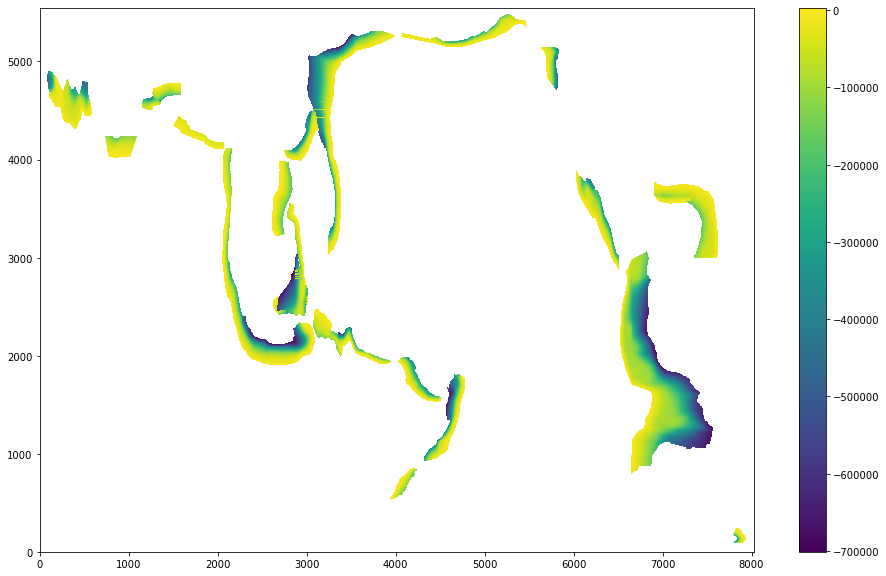

In [90]:
#test plot, not perfect but alright?
plt.figure(figsize=(16,10))
plt.pcolormesh(grid.values)
plt.colorbar()

In [ ]:
# Fetch all Slab2 subduction zones and add them inside a list
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))

#merge into global
global_sub_zones = xr.merge([grid for grid in subduction_zones])

In [8]:
#define line for cross section
#we need two types of cross sections, one for slab 2.0
#one for pygmt
#they, unfortunately, have to be built in different ways

#slab2.0
lat1 = key[0]
lon1 = key[2]
lat2 = key[1]
lon2 = key[3]
cross_section_line = slab_workflow.cross_section_line_pygplates(lat1,lon1,lat2,lon2,0.1)

#get the iso-subchrons that intersect the cross section line

intersecting_lines = []
for ind, polyline in enumerate(output_data):
    
    #get min distance between 'iso-sub-chron' and our cross section
    min_distance_to_feature = pygplates.GeometryOnSphere.distance(polyline[1],cross_section_line)
    #if min distance is 0, then they intersect and we want the rest of the data
    if min_distance_to_feature == 0:
        intersecting_lines.append(polyline)
        

steps = 200
lat = np.linspace(lat1,lat2, int(steps))
lon = np.linspace(lon1,lon2, int(steps))
#pygmt track needs lon/lat as separate columns in pandas dataframe
d = { 'lon': lon,'lat': lat}
points = pd.DataFrame(data=d)



In [9]:
###main calculation, get data from cross sections

# Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')
track_uncertain = pygmt.grdtrack(points=points, grid=grid_uncertainty, newcolname='depth_uncertainty')
#the df will contain some NaNs that we want to filter
track_dropna = track.dropna()
track_uncertain_dropna = track_uncertain.dropna()
#our data so far
track_dropna['depth'] = track_dropna['depth'] * -0.001

track_uncertain_dropna['depth_uncertainty'] = track_uncertain_dropna['depth_uncertainty'] * 0.001
#get points intersecting the cross section from slab 2.0
intersecting_points_reversed, intersecting_points, interpolated_variables, interpolated_depths = slab_workflow.get_intersecting_values(intersecting_lines, cross_section_line)

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [10]:
#calculate distance as going across cross section
distances = []
cum_distances = []
for ind, i in enumerate(intersecting_points_reversed):
    if ind == 0:
        distance = 0
    else:
        distance = pygplates.GeometryOnSphere.distance(i[1], intersecting_points_reversed[ind-1][1])
        
    #to convert from radians to km we have to multiply by radius,
    #but as we are at depth, the radius is slightly different
    radius = pygplates.Earth.mean_radius_in_kms - interpolated_depths[::-1][ind]
    distances.append(distance*radius)
    cum_distances.append(np.sum(distances))
#use haversine formula to convert to km
#get distance, equally spaced so we can define at the start
lat1 = track_dropna['lat'].values[0]
lat2 = track_dropna['lat'].values[1]
lon1 = track_dropna['lon'].values[0]
lon2 = track_dropna['lon'].values[1]
# convert decimal degrees to radians 
lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

# haversine formula 
dlon = lon2 - lon1
dlat = lat2 - lat1 
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

c = 2 * np.arcsin(np.sqrt(a)) 
r = 6371 # Radius of earth in kilometers. Use 3956 for miles

distance = c*r

#get the incremental range
distance_range = []
for i in range(track_dropna['depth'].count()):

    distance_range.append(i*distance)
    

In [11]:
# Options for Model are:
#  - D80
#  - X25
#  - W1300
#  - T550
MODEL = 'D80'

SlabDir = '/Users/Andrew/Documents/PhD/Data/syracuse_thermal/Syracuse++_supp_Material/models/%s' % MODEL

files=[]
for(dirpath,dirnames,filenames) in walk(SlabDir):
    files.extend(filenames)
    break
files.sort()
#print f
arcs = []
for file in files:
    arcs.append(file.split('.')[0])
    
#slab surface | moho surface | slab curie depth | magnetite depth | moho curie depth
surface_arrays = []
isotherm_arrays = []
for j in np.arange(len(files)):

        FNAME = files[j]

        tmp_surface_arrays, tmp_isotherm_arrays = slab_workflow.get_slab_surfaces(SlabDir, FNAME)
        surface_arrays.append(tmp_surface_arrays)
        isotherm_arrays.append(tmp_isotherm_arrays)

        
#NB results are:
#surface (0 for top of slab, 7 for moho) | horiontal distance from trench | depth | temperature

In [13]:
input_lat = np.mean(lat)
input_lon = np.mean(lon)
if input_lon > 180:
    input_lon = input_lon-360
#get closest based on lat
df_sort = df.iloc[(df['Lat']-int(input_lat)).abs().argsort()[:10]]
#now cross check for long
df_closest = df_sort.iloc[(df_sort['Lon']-int(input_lon)).abs().argsort()[:1]]
print(df_closest['Name'])
#to get index
closest_index = df_closest.index.tolist()


28    N_Honshu
Name: Name, dtype: object


In [14]:
#index of closest will correspond to our slab surface database index
index_of_closest = slab_workflow.find_with_list(arcs, df_closest['Name'].values[0])
thermal_data_of_closest = surface_arrays[index_of_closest[0]]

In [16]:
def find_with_list(myList, target):
    '''
    find index of thing in list
    '''

    inds = []
    for i in range(len(myList)):
        if myList[i] == target:
            inds += i,
    return inds

In [17]:
def _find_nearest(array, value):
    """Find the index in array whose element is nearest to value.

    Parameters
    ----------
    array : np.array
      The array.

    value : number
      The value.

    Returns
    -------
    integer
      The index in array whose element is nearest to value.

    """
    if array.argmax() == array.size - 1 and value > array.max():
        return array.size
    return (np.abs(array - value)).argmin()

In [18]:
interpolated_variables

[0.6655912985268835,
 0.6660519681501146,
 0.43899319193355113,
 0.3489283323287964,
 0.3492430746555328,
 0.34720641374588024,
 0.34830933809280396,
 0.35324850678443903,
 0.35174107551574707,
 0.3482416272163392,
 0.3504540920257568]

In [19]:
#here we map peridotite concentrations from our slab warping using the corrected depths
#to cross section depth from Slab2.0 (as the indices of interpolated depth and peridotite are the same)

#we want to use the depths from the slab 2.0 geometry as our 'base model'
base_cross_section_depths = np.asarray(track_dropna['depth'])#thermal_data_of_cross_section[0][::,2]
#interpolated depths to match to base cross section depth
interpolated_depths = np.asarray(interpolated_depths)
#get nearest indices
vec_nearest = lambda x: _find_nearest(interpolated_depths, x)
index_of_nearest_depth = np.vectorize(vec_nearest)(base_cross_section_depths)

#find peridotite values at index
perid_at_depth = []
for ind,i in enumerate(index_of_nearest_depth):
    #print(i)
    perid = interpolated_variables[i]

    perid_at_depth.append(perid)
perid_at_depth = np.asarray(perid_at_depth)


In [76]:
#now we do the same but with thermal profiles
#0 for slab surface, 1 for slab moho
syracuse_depths = thermal_data_of_closest[1][::,2]
syracuse_temps = thermal_data_of_closest[1][::,3]
#get nearest indices
vec_nearest = lambda x: _find_nearest(syracuse_depths, x)
index_of_nearest_depth = np.vectorize(vec_nearest)(base_cross_section_depths)

temp_at_depth = []
for ind,i in enumerate(index_of_nearest_depth):
    if i == len(syracuse_depths):
        temperature = syracuse_temps[i-1]
    #print(i)
    else:
        temperature = syracuse_temps[i]

    temp_at_depth.append(temperature)

temp_at_depth = np.asarray(temp_at_depth)

#add to our dataframe
track_dropna['temp'] = temp_at_depth

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
SurfaceArray_plot = surface_arrays[index_of_closest[0]][0]
MohoArray_plot = surface_arrays[index_of_closest[0]][1]

In [36]:
# now we gonna add in pressure to our depths, just using lithostatic pressure
# P = rho * g * depth
#assume 30 km for continenta crust?
density = np.ones_like(track_dropna['depth'])
continental_curst_rho = 2.83
mantle_rho = 3.3

for ind,i in enumerate(track_dropna['depth']):
    if i <=30:
        density[ind] = continental_curst_rho
    else:
        density[ind] = mantle_rho
#add to our dataframe
track_dropna['density'] = density        

In [72]:
#calculate pressure at each depth
pressure = np.ones_like(track_dropna['density'].values)

for ind, i in enumerate(pressure):
    #if we are at the max length then we need all values
    if ind == len(track_dropna['depth'].values) - 1:
        pressure[ind] = calcualte_pressure(track_dropna['density'].values,track_dropna['depth'].values)
    else:
        pressure[ind] = calcualte_pressure(track_dropna['density'].values[:ind+1],
                                           track_dropna['depth'].values[:ind+1])
    
#add pressure to our dataframe, convert to gigapascals
track_dropna['pressure'] = pressure * 1e-3 

/opt/anaconda3/envs/Python3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [74]:
len(track_dropna['pressure'])

124

In [77]:
track_dropna

,lon,lat,depth,density,pressure,temp
23,146.497487,42.040201,10.336289,2.83,0.286667,45.758
24,146.432161,42.085427,11.056945,2.83,0.306653,45.758
25,146.366834,42.130653,11.835531,2.83,0.328247,45.758
26,146.301508,42.175879,12.688613,2.83,0.351906,45.758
27,146.236181,42.221106,13.619607,2.83,0.377726,45.758
...,...,...,...,...,...,...
142,138.723618,47.422111,473.432419,3.30,15.181769,637.335
143,138.658291,47.467337,477.615752,3.30,15.317058,637.335
144,138.592965,47.512563,481.756900,3.30,15.450982,637.335
145,138.527638,47.557789,485.849495,3.30,15.583337,637.335


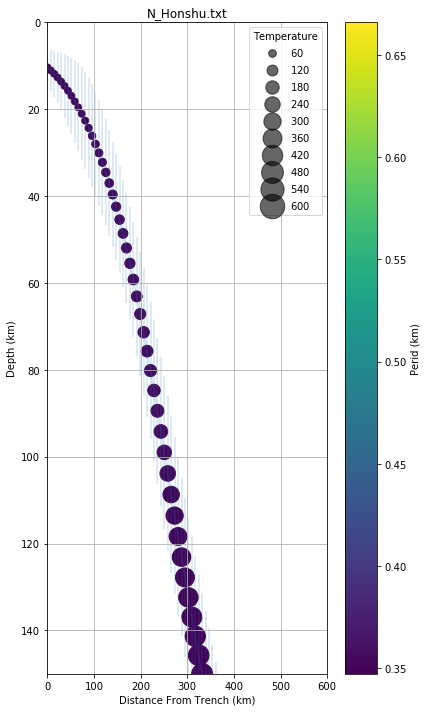

In [23]:

fig, ax = plt.subplots(figsize=(6,10))

#ax.plot(SurfaceArray_plot[:,1],SurfaceArray_plot[:,2],'k',ls='--', zorder=2)
#ax.plot(MohoArray_plot[:,1],MohoArray_plot[:,2],'g',ls='-.', zorder=2)


scatter = ax.scatter(np.asarray(distance_range),
            track_dropna['depth'].values,c=perid_at_depth,s=temp_at_depth, cmap=plt.cm.viridis)
#plt.plot(np.asarray(distance_range),
#            track_dropna['depth'].values, lw=10)
ax.errorbar(np.asarray(distance_range),
            track_dropna['depth'].values,
            yerr=track_uncertain_dropna['depth_uncertainty'].values,
            alpha=0.2, zorder=1)
#plot = ax.scatter(SurfaceArray_plot[:,1]-7,SurfaceArray_plot[:,2],s=30,c=SurfaceArray_plot[:,3],\
#            cmap=plt.cm.gnuplot,edgecolor='none',vmin=100,vmax=800, zorder=2)
#ax.scatter(MohoArray_plot[:,1]-7,MohoArray_plot[:,2],s=30,c=MohoArray_plot[:,3],\
#            cmap=plt.cm.gnuplot,edgecolor='none',vmin=100,vmax=800, zorder=2)

#ax.scatter(np.asarray(cum_distances),
#            np.asarray(interpolated_depths[::-1]+10),
#           c='k')
#ax.plot(np.asarray(cum_distances),
#         np.asarray(interpolated_depths[::-1]+10), alpha=0.5, c='k')
#ax.plot(np.asarray(cum_distances),
#         np.asarray([i[2]+10 for i in intersecting_points_reversed]), alpha=0.5, c='b', ls='-.')


ax.set_xlabel('Distance From Trench (km)')
ax.set_ylabel('Depth (km)')
ax.set_xlim([0,600])
ax.set_ylim([0,150])
ax.invert_yaxis()
ax.set_title(files[index_of_closest[0]])

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Temperature")


cbar = fig.colorbar(scatter)
cbar.set_label('Perid (km)')
fig.tight_layout()
ax.grid()

#[left, bottom, width, height]


now we are just going to plot a few maps to show the context of what we are seeing

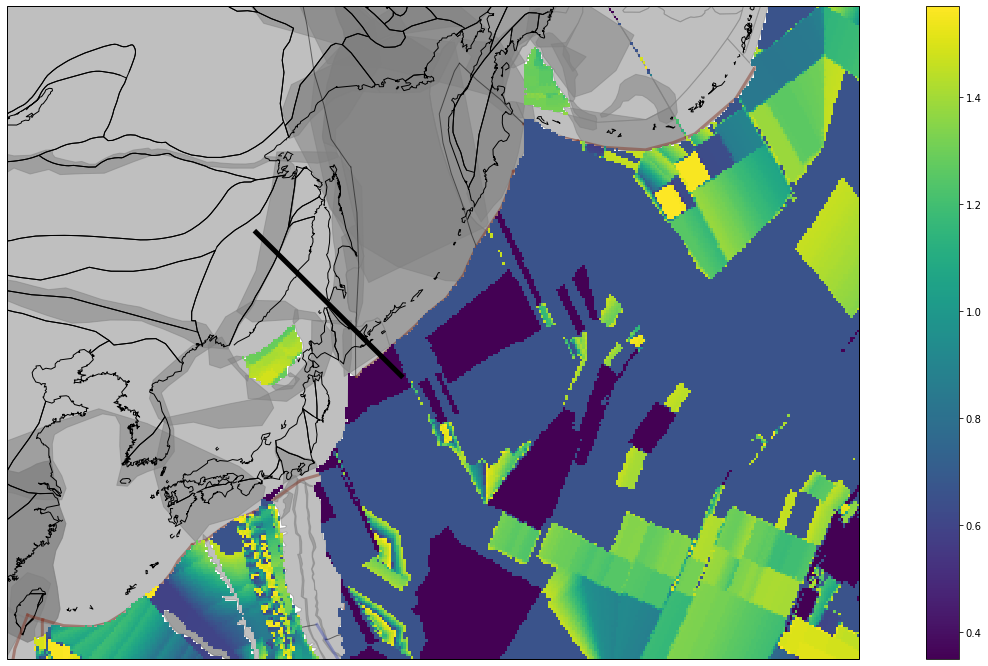

In [140]:
#globe plotting
times = np.arange(0,1,1)
for time in times:
    raster_dir = '/Users/Andrew/Documents/PhD/Scripts/Scripts_Output/Chapman_2019/'
    raster_file = '%speridotite_thickness_post_serpentinisation%s_Ma.nc' % (raster_dir, time)
    #raster_file = '%sserpentinite_thickness_%s_Ma.nc' % (raster_dir, time)
    peridotite_grid = xr.open_dataset('%s' % raster_file)
    #plate data
    rotation_filename = '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS.rot'

    input_topology_filename = ['/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',
                               '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

    coastline_polygons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Coastlines/Matthews_etal_GPC_2016_Coastlines.gpmlz'
    isochrons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Isochrons/Muller_etal_AREPS_2016_Isochrons.gpmlz'
    COBs = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'


    #topology_features = pygplates.FeatureCollection(input_topology_filename)
    rotation_model = pygplates.RotationModel(rotation_filename)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
                           subplot_kw={'projection': ccrs.Orthographic(central_longitude=np.mean(lon),
                                                                       central_latitude=np.mean(lat))})
    data_crs = ccrs.Geodetic()
    poly_data_crs = ccrs.PlateCarree()
    date_line_wrapper = pygplates.DateLineWrapper(0)

    reconstructed_polygons = []
    reconstructed_isochrons = []
    reconstructed_COBs = []

    # Alternative method using 'partition_geometry'
    resolved_topologies = []
    shared_boundary_sections = []

    pygplates.resolve_topologies(input_topology_filename, rotation_model,
                                 resolved_topologies, int(time), shared_boundary_sections)


    pygplates.reconstruct(coastline_polygons,rotation_model, reconstructed_polygons, int(time))
    pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))
    pygplates.reconstruct(isochrons,rotation_model, reconstructed_isochrons, int(time))

    ax.plot([lon[0], lon[-1]],
            [lat[0], lat[-1]], transform=poly_data_crs, c='k',lw=5,zorder=3)

    for polygon in reconstructed_polygons:
        poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
        wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
        for wrapped_poly in wrapped_polys:
            wrapped_poly_lat = []
            wrapped_poly_lon = []
            for wrapped_poly_point in wrapped_poly.get_exterior_points():
                wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
                wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

            ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)

    for polygon in reconstructed_COBs:
        poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
        wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
        for wrapped_poly in wrapped_polys:
            wrapped_poly_lat = []
            wrapped_poly_lon = []
            for wrapped_poly_point in wrapped_poly.get_exterior_points():
                wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
                wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

            #ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
            ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='grey', alpha=0.5,
                    linewidth=1 ,zorder=0, transform=poly_data_crs)

    for shared_boundary_section in shared_boundary_sections:
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                            linewidth=3, alpha=0.5, zorder=1, transform=data_crs)

        elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                            linewidth=3, alpha=0.5, zorder=1, transform=data_crs)                
        else:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                            linewidth=1, alpha=0.5, zorder=1, transform=data_crs)


    plot = ax.imshow(peridotite_grid['peridotite_thickness_post_serpentinisation'], origin='lower', transform=poly_data_crs, zorder=2)
    fig.colorbar(plot)
    #cbar.set_title('Peridotite (km)')
    #ax.set_global()
    ax.set_extent([120, 180, 20, 60])

In [79]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12),
#                       subplot_kw={'projection': ccrs.Orthographic(central_longitude=np.mean(lon),
#                                                                   central_latitude=np.mean(lat))})
#data_crs = ccrs.Geodetic()
#poly_data_crs = ccrs.PlateCarree()
#date_line_wrapper = pygplates.DateLineWrapper(0)
#
#reconstructed_polygons = []
#reconstructed_isochrons = []
#reconstructed_COBs = []
#
## Alternative method using 'partition_geometry'
#resolved_topologies = []
#shared_boundary_sections = []
#
#pygplates.resolve_topologies(input_topology_filename, rotation_model,
#                             resolved_topologies, int(time), shared_boundary_sections)
#
#
#pygplates.reconstruct(coastline_polygons,rotation_model, reconstructed_polygons, int(time))
#pygplates.reconstruct(COBs,rotation_model, reconstructed_COBs, int(time))
#pygplates.reconstruct(isochrons,rotation_model, reconstructed_isochrons, int(time))
#
#ax.plot([lon[0], lon[-1]],
#        [lat[0], lat[-1]], transform=poly_data_crs, c='k',lw=5,zorder=3)
#
#for polygon in reconstructed_polygons:
#    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
#    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
#    for wrapped_poly in wrapped_polys:
#        wrapped_poly_lat = []
#        wrapped_poly_lon = []
#        for wrapped_poly_point in wrapped_poly.get_exterior_points():
#            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
#            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())
#
#        ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
#    
#for polygon in reconstructed_COBs:
#    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
#    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
#    for wrapped_poly in wrapped_polys:
#        wrapped_poly_lat = []
#        wrapped_poly_lon = []
#        for wrapped_poly_point in wrapped_poly.get_exterior_points():
#            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
#            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())
#
#        #ax.plot(wrapped_poly_lon, wrapped_poly_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
#        ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='grey', alpha=0.5,
#                linewidth=1 ,zorder=0, transform=poly_data_crs)
#        
#for shared_boundary_section in shared_boundary_sections:
#    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
#        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
#            tmp = shared_sub_segment.get_resolved_geometry()
#            wrapped_polylines = date_line_wrapper.wrap(tmp)
#            for wrapped_polyline in wrapped_polylines:
#                mor_wrapped_point_lat = []
#                mor_wrapped_point_lon = []
#                for wrapped_point in wrapped_polyline.get_points():
#                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
#                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
#                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
#                        linewidth=3, alpha=0.5, zorder=1, transform=data_crs)
#                
#    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
#        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
#            tmp = shared_sub_segment.get_resolved_geometry()
#            wrapped_polylines = date_line_wrapper.wrap(tmp)
#            for wrapped_polyline in wrapped_polylines:
#                mor_wrapped_point_lat = []
#                mor_wrapped_point_lon = []
#                for wrapped_point in wrapped_polyline.get_points():
#                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
#                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
#                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
#                        linewidth=3, alpha=0.5, zorder=1, transform=data_crs)                
#    else:
#        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
#            tmp = shared_sub_segment.get_resolved_geometry()
#            wrapped_polylines = date_line_wrapper.wrap(tmp)
#            for wrapped_polyline in wrapped_polylines:
#                mor_wrapped_point_lat = []
#                mor_wrapped_point_lon = []
#                for wrapped_point in wrapped_polyline.get_points():
#                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
#                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
#                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
#                        linewidth=1, alpha=0.5, zorder=1, transform=data_crs)
#
#
#plot = ax.imshow(peridotite_grid['peridotite_thickness_post_serpentinisation'], origin='lower', transform=poly_data_crs, zorder=2)
#fig.colorbar(plot)
##cbar.set_title('Peridotite (km)')
##ax.set_global()
#ax.set_extent([100, 165, 0, 60])

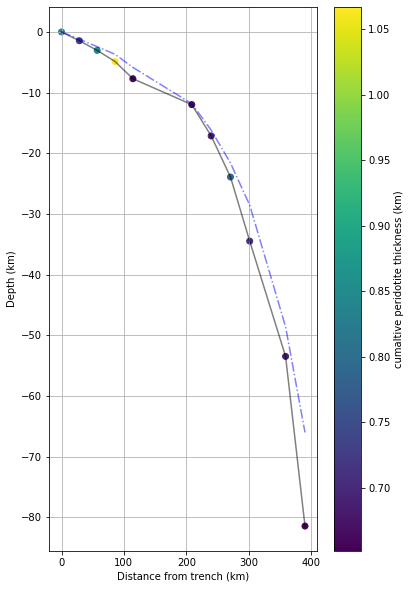

In [80]:
plt.figure(figsize=(6,10))
plt.scatter(np.asarray(cum_distances),
            np.asarray(interpolated_depths[::-1]) *-1,
           c=np.asarray(interpolated_variables))
plt.plot(np.asarray(cum_distances),
         np.asarray(interpolated_depths[::-1]) *-1, alpha=0.5, c='k')
plt.plot(np.asarray(cum_distances),
         np.asarray([i[2]*-1 for i in intersecting_points_reversed]), alpha=0.5, c='b', ls='-.')
plt.colorbar(label='cumaltive peridotite thickness (km)')
#plt.gca().set_xlim([0, 400])
#plt.gca().set_ylim([-200,0])
plt.xlabel('Distance from trench (km)')
plt.ylabel('Depth (km)')
plt.grid()